<a href="https://colab.research.google.com/github/benschlup/csck507_team_a/blob/main/CSCK507_Team_A_WikiQA_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
### **CSCK507 Natural Language Processing, March-May 2022: End-of-Module Assignment**
# **Generative Chatbot**
---
#### Team A
Muhammad Ali (Student ID 200050027)  
Benjamin Schlup (Student ID 200050007)  
Chinedu Abonyi (Student ID 200050028)  
Victor Armenta-Valdes (Student ID 222500001)

---
# **Data Analysis**
---

Dataset being used: https://www.microsoft.com/en-us/download/details.aspx?id=52419  
Paper on dataset: https://aclanthology.org/D15-1237/  

---
## 1. Configuration and framework

In [2]:
# Imports
import os
import re
import urllib.request
import zipfile

import numpy as np
import pandas as pd

from keras_preprocessing.text import Tokenizer

---
## 2. Data acquisition and loading

In [3]:
# Download data: If link does not work any longer, access file manually from here: https://www.microsoft.com/en-us/download/details.aspx?id=52419
urllib.request.urlretrieve("https://download.microsoft.com/download/E/5/F/E5FCFCEE-7005-4814-853D-DAA7C66507E0/WikiQACorpus.zip", "WikiQACorpus.zip")

('WikiQACorpus.zip', <http.client.HTTPMessage at 0x7f499c6c5990>)

In [4]:
# Extract files
with zipfile.ZipFile('WikiQACorpus.zip', 'r') as zipfile:
   zipfile.extractall()

In [5]:
# Import questions and answers: training, validation and test datasets
train_df = pd.read_csv( f'./WikiQACorpus/WikiQA-train.tsv', sep='\t', encoding='ISO-8859-1')
val_df = pd.read_csv( f'./WikiQACorpus/WikiQA-dev.tsv', sep='\t', encoding='ISO-8859-1')
test_df = pd.read_csv( f'./WikiQACorpus/WikiQA-test.tsv', sep='\t', encoding='ISO-8859-1')       

---
## 3. Statistics

In [6]:
# Quality checks and exploratory data analysis removed: dataset has proven clean
# Print gross volumes:
print(f'Gross training dataset size: {len(train_df)}')
print(f'Gross validation dataset size: {len(val_df)}')
print(f'Gross test dataset size: {len(test_df)}')

Gross training dataset size: 20347
Gross validation dataset size: 2733
Gross test dataset size: 6116


In [7]:
# Get idea about structure
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20347 entries, 0 to 20346
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   QuestionID     20347 non-null  object
 1   Question       20347 non-null  object
 2   DocumentID     20347 non-null  object
 3   DocumentTitle  20347 non-null  object
 4   SentenceID     20347 non-null  object
 5   Sentence       20347 non-null  object
 6   Label          20347 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [8]:
# Show sample of data: Confirm that we talk about broad (i.e. open domain) question/answer set
train_df.sample(10)

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
17338,Q2552,when is the house of night book awakened comin...,D2386,House of Night,D2386-8,"The series, which is published by St Martin's ...",0
5670,Q806,how old old is xp operating system,D780,Windows XP,D780-14,According to web analytics data generated by N...,0
18861,Q2790,where was the first march madness game played,D2593,NCAA Men's Division I Basketball Championship,D2593-9,Lower-ranked teams are placed in the bracket a...,0
2764,Q381,how does the brain process language,D379,Language processing,D379-3,Most recent theories consider that this proces...,0
5827,Q827,how does milk turn into different types of ch...,D801,Cheese,D801-4,Cheese consists of proteins and fat from milk ...,0
1552,Q217,what does 1 year mean to the planet,D217,Earth,D217-10,"The planet's interior remains active, with a s...",0
4759,Q665,How did the flag of chile get created,D649,Flag of Chile,D649-2,The Chilean flag is also known in Spanish as L...,0
13362,Q1949,who replaced nikita khrushchev,D1840,Nikita Khrushchev,D1840-8,"In 1939, Stalin sent him to govern Ukraine , a...",0
11313,Q1625,what are the colors of newfoundland and labrador,D1542,Newfoundland and Labrador,D1542-9,A former colony and dominion of the United Kin...,0
20103,Q3005,what is in the alpine mountain systems,D2774,Alps,D2774-9,"By the 6th century BC, the Celtic La TÃ¨ne cul...",0


In [9]:
# Check if there are any unavailable values
print('Null values in training, validation or test data set:', train_df.isnull().values.any() | val_df.isnull().values.any() | test_df.isnull().values.any())

Null values in training, validation or test data set: False


In [10]:
# Check how many rows actually contain correct answers (label==1): we only have 1039 correct answers -> probably too limited for open domain training if only using these for training
correct_answers = sum(train_df['Label']==1)
total_answers = len(train_df.index)
print(f'Correct answers: {correct_answers} ({correct_answers*100/total_answers:.2f}%)')

Correct answers: 1039 (5.11%)


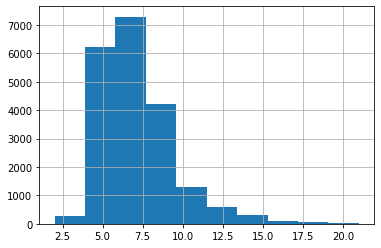

In [11]:
# Look at average question length in words: long tail above 10 words
train_df['Question'].str.split().map(lambda x: len(x)).hist()

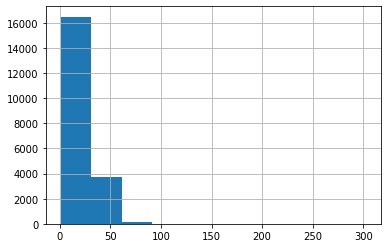

In [12]:
# Look at average answer length in words: long tail above 50 words
train_df['Sentence'].str.split().map(lambda x: len(x)).hist()

In [13]:
# Estimate vocabulary size (without data cleansing/preparation yet): vocabulary size reasonable
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['Question'])
print(f'Question vocabulary size based on training dataset: {len(tokenizer.word_index) + 1}')

Question vocabulary size based on training dataset: 4081


In [14]:
# Estimate vocabulary size (without data cleansing/preparation yet): Answers seem to have prohibitely broad vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['Sentence'])
print(f'Answer vocabulary size based on training dataset: {len(tokenizer.word_index) + 1}')

Answer vocabulary size based on training dataset: 32278


---
# END OF NOTEBOOK
---